# Predictive Risk Modeling → Personalized Policy


In [1]:
# =============================
# 0) Imports & Data Load
# =============================
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix

from IPython.display import display

# Plot styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Connect & load
conn = duckdb.connect('../bree_case_study.db')
df = conn.execute("SELECT * FROM v_risk_model_base").df()
print("Shape:", df.shape)
df.head()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Shape: (6536, 56)


,loan_id,user_id,amount,is_default,approved_at_utc,disbursed_at_utc,due_date_clean,province,device_os,acquisition_channel,...,net_cashflow_14d,net_cashflow_30d,inflow_vol_to_netcashflow_14d,bal_vol_to_netcashflow_14d,inflow_vol_to_netcashflow_30d,bal_vol_to_netcashflow_30d,cashin_to_cashout_14d,cashin_to_cashout_30d,overdraft_txshare_14d,overdraft_txshare_30d
0,L4703-1,4703,148.33,1,2025-03-25 19:07:12.029978-04:00,2025-03-26 02:51:43.559554-04:00,2025-04-09,ON,ios,email,...,1197.64,1703.93,0.115755,0.141371,0.060129,0.177777,1.312761,0.663783,1.0,1.0
1,L4741-1,4741,134.09,0,2025-03-29 11:01:08.268203-04:00,2025-03-29 12:57:05.345972-04:00,2025-04-12,NB,android,organic,...,465.91,672.30,0.000000,0.270293,0.000000,0.304516,0.000000,0.000000,1.0,1.0
2,L4748-2,4748,284.63,0,2025-07-11 23:25:44.070332-04:00,2025-07-12 07:51:04.499329-04:00,2025-07-26,AB,android,referral,...,1560.93,2785.98,0.142456,0.210840,0.060086,0.091441,1.644882,1.225366,1.0,1.0
3,L4868-1,4868,133.27,0,2025-06-21 07:20:21.731854-04:00,2025-06-21 10:40:18.344959-04:00,2025-07-05,AB,android,organic,...,2446.82,3262.79,0.124658,0.212178,0.067333,0.140776,3.367606,1.370886,1.0,1.0
4,L4885-1,4885,135.55,0,2025-05-19 10:18:49.181101-04:00,2025-05-19 10:42:19.007077-04:00,2025-06-02,ON,ios,paid_social,...,1688.83,2514.07,0.200842,0.334125,0.082458,0.150847,4.132442,1.178023,1.0,1.0


In [2]:
# =============================
# 1) Build Feature List Dynamically
# =============================

target = "is_default"

# Columns to drop (IDs, timestamps, outcomes, leakage features, economics)
drop_cols = [
    target,              # label
    # leakage features
    'loan_id',
    'user_id',
    'approved_at_utc',
    'disbursed_at_utc',
    'due_date_clean','amount'
]

# Keep only columns that exist in this df
drop_cols = [c for c in drop_cols if c in df.columns]

# Dynamic feature list = everything else
feature_cols = [c for c in df.columns if c not in drop_cols]

print("Features used:", feature_cols)

# Build feature matrix
X_raw = df[feature_cols].copy()
y = df[target].astype(int)

# One-hot encode categoricals
X = pd.get_dummies(X_raw, drop_first=True)

# Clean up infinities / nulls
from sklearn.impute import SimpleImputer
# Replace inf/-inf with NaN first
X = X.replace([np.inf, -np.inf], np.nan)

# Median imputation
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

print("Final feature count:", X.shape[1])


Features used: ['province', 'device_os', 'acquisition_channel', 'baseline_risk_score', 'payroll_frequency', 'prior_loan_flag', 'prior_loan_default_flag', 'prior_avg_days_late', 'prior_avg_amount', 'prior_avg_revenue_to_loan', 'prior_tip_take_rate', 'prior_approved_loans_count', 'prior_unapproved_loans_count', 'txn_info_found', 'inflow_sum_14d', 'spend_sum_14d', 'essentials_spend_sum_14d', 'rent_spend_sum_14d', 'txn_count_14d', 'neg_txn_count_14d', 'inflow_mean_14d', 'inflow_std_14d', 'bal_mean_14d', 'bal_std_14d', 'inflow_sum_30d', 'spend_sum_30d', 'essentials_spend_sum_30d', 'rent_spend_sum_30d', 'txn_count_30d', 'neg_txn_count_30d', 'inflow_mean_30d', 'inflow_std_30d', 'bal_mean_30d', 'bal_std_30d', 'days_since_last_payroll', 'rent_share_outflows_14d', 'essentials_share_14d', 'rent_share_outflows_30d', 'essentials_share_30d', 'net_cashflow_14d', 'net_cashflow_30d', 'inflow_vol_to_netcashflow_14d', 'bal_vol_to_netcashflow_14d', 'inflow_vol_to_netcashflow_30d', 'bal_vol_to_netcashflow_

In [3]:

# =============================
# 2) Train / Test Split
# =============================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape, y_train.mean().round(3), y_test.mean().round(3))



(4575, 64) (1961, 64) 0.253 0.252


In [4]:
# =============================
# 3) Logistic Regression (L1 / LASSO) with CV
# =============================
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# Candidate C values (inverse of regularization strength)
C_values = np.logspace(-3, 1, 9)  # e.g. [0.001 ... 10]

lasso_cv = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegressionCV(
        Cs=C_values,
        penalty="l1",
        solver="saga",
        cv=5,                # 5-fold cross-validation
        scoring="roc_auc",
        max_iter=5000,
        random_state=42,
        n_jobs=-1
    ))
])

# Train
lasso_cv.fit(X_train, y_train)

# Best regularization strength
best_C = float(lasso_cv.named_steps["clf"].C_[0])
print("Best C:", best_C)

# Feature coefficients
coef = pd.Series(lasso_cv.named_steps["clf"].coef_[0], index=X_train.columns)

# Keep only non-zero features
kept = coef[coef != 0].sort_values(ascending=False)
if kept.empty:
    print("No features selected (all coefficients shrunk to 0).")
else:
    print("Non-zero features (top 20):")
    display(kept.head(20))
    print(f"Kept {kept.size} / {coef.size} features")


Best C: 0.01
Non-zero features (top 20):


baseline_risk_score    0.202386
dtype: float64

Kept 1 / 64 features


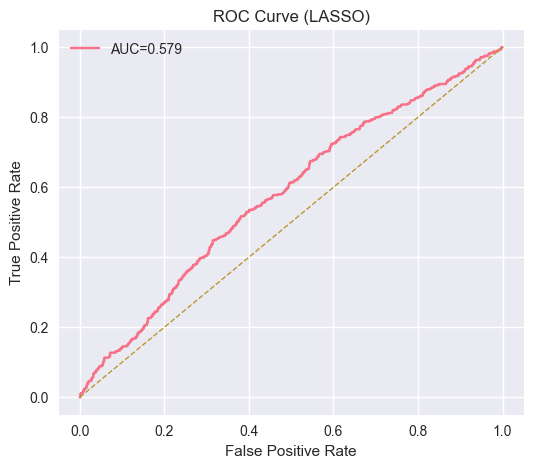

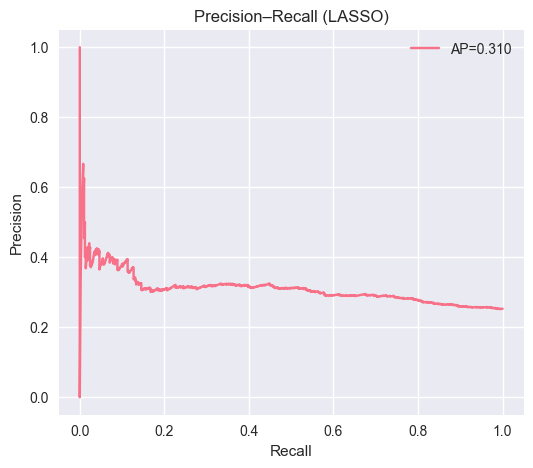

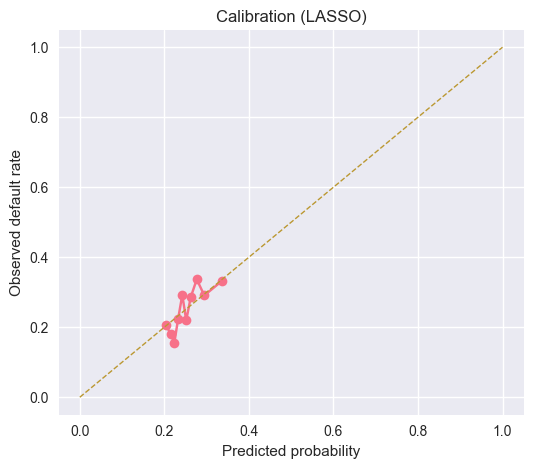

AUC=0.579  |  AP=0.310  |  Brier=0.186  |  LogLoss=0.559


In [5]:
# =============================
# 4) Evaluation: ROC, PR, Calibration
# =============================
from sklearn.metrics import brier_score_loss, log_loss

from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

y_pred_prob = lasso_cv.predict_proba(X_test)[:, 1]

# AUC / ROC
auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (LASSO)")
plt.legend()
plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_test, y_pred_prob)
ap = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (LASSO)")
plt.legend()
plt.show()

# Calibration
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10, strategy="quantile")
# Calibration metrics
brier = brier_score_loss(y_test, y_pred_prob)
ll = log_loss(y_test, y_pred_prob)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("Predicted probability")
plt.ylabel("Observed default rate")
plt.title("Calibration (LASSO)")
plt.show()




print(f"AUC={auc:.3f}  |  AP={ap:.3f}  |  Brier={brier:.3f}  |  LogLoss={ll:.3f}")


Stability by province:


,province,n_samples,AUC,AP
4,ON,714,0.596,0.340
5,QC,455,0.588,0.329
1,BC,277,0.615,0.346
0,AB,203,0.469,0.220
2,MB,86,0.588,0.421
6,SK,58,0.492,0.360
3,NS,57,0.527,0.231


Stability by device_os:


,device_os,n_samples,AUC,AP
1,ios,1019,0.582,0.295
0,android,942,0.577,0.334


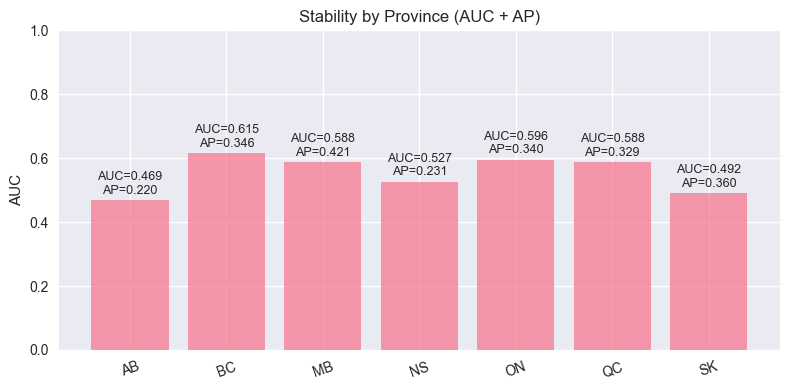

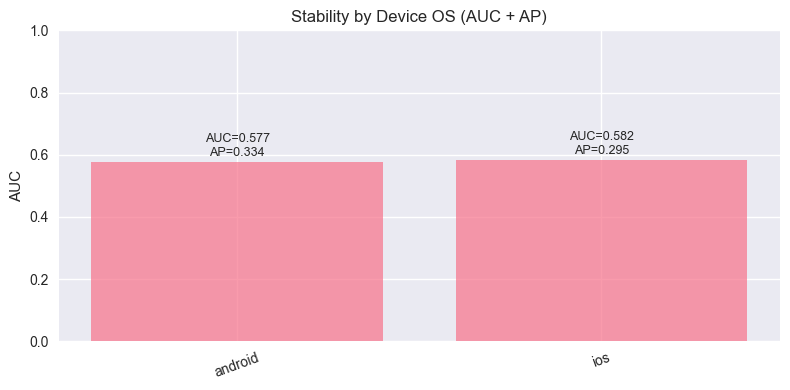

In [6]:
# =============================
# 5) Stability across segments + plots
# =============================
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score

# Align test rows back to original df for segment columns
df_test = df.loc[X_test.index].copy()

def eval_segment(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    return auc, ap

def evaluate_stability(df_seg, y_true, y_prob, segment_col, min_n=50):
    rows = []
    for seg in sorted(df_seg[segment_col].dropna().unique()):
        mask = (df_seg[segment_col] == seg)
        if mask.sum() < min_n:
            continue
        auc, ap = eval_segment(y_true[mask], y_prob[mask])
        rows.append({segment_col: seg, "n_samples": int(mask.sum()),
                     "AUC": round(auc, 3), "AP": round(ap, 3)})
    return pd.DataFrame(rows)

stab_prov = evaluate_stability(df_test, y_test, y_pred_prob, "province")
stab_os   = evaluate_stability(df_test, y_test, y_pred_prob, "device_os")

print("Stability by province:")
display(stab_prov.sort_values("n_samples", ascending=False))
print("Stability by device_os:")
display(stab_os.sort_values("n_samples", ascending=False))

# --- Plots with metrics in labels ---
def bar_with_metrics(df_res, cat_col, title):
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.bar(df_res[cat_col].astype(str), df_res["AUC"], alpha=0.7)
    for i, (auc, ap) in enumerate(zip(df_res["AUC"], df_res["AP"])):
        ax1.text(i, auc + 0.01, f"AUC={auc:.3f}\nAP={ap:.3f}", ha='center', va='bottom', fontsize=9)
    ax1.set_ylim(0, 1)
    ax1.set_ylabel("AUC")
    ax1.set_title(title)
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

bar_with_metrics(stab_prov, "province", "Stability by Province (AUC + AP)")
bar_with_metrics(stab_os, "device_os", "Stability by Device OS (AUC + AP)")


,name,threshold,approval_rate,def_rate_approved,def_rate_declined,sensitivity,specificity,precision
0,Fixed Approval 30%,0.227355,0.299847,0.181973,0.282593,0.783838,0.328104,0.282593
1,Fixed Approval 35%,0.232453,0.349822,0.185131,0.288627,0.743434,0.381310,0.288627
2,Fixed Approval 40%,0.237435,0.399286,0.192848,0.292020,0.694949,0.431105,0.292020
3,Fixed Default ≤ 19%,0.235188,0.375829,0.189959,0.290033,0.717172,0.407231,0.290033
4,Fixed Default ≤ 25%,0.370868,0.987251,0.250000,0.440000,0.022222,0.990450,0.440000
5,Fixed Default ≤ 30%,1.000000,1.000000,0.252422,NaN,0.000000,1.000000,NaN


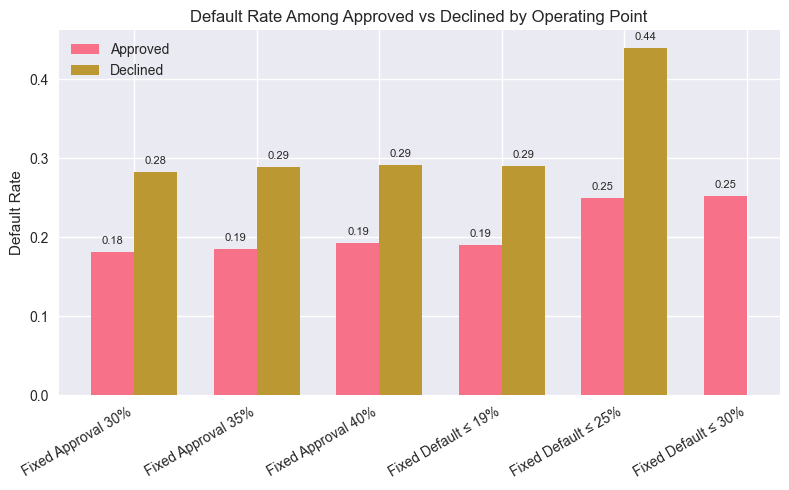

In [7]:
# =============================
# 6) Operating Points: fixed approvals & fixed default targets
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evaluate_point(y_true, y_prob, threshold, name):
    """Return metrics dict for a given threshold."""
    pred = (y_prob >= threshold).astype(int)  # 1 = decline, 0 = approve
    tn, fp, fn, tp = confusion_matrix(y_true, pred, labels=[0,1]).ravel()

    approved = (y_prob < threshold)
    declined = ~approved

    return {
        "name": name,
        "threshold": threshold,
        "approval_rate": approved.mean(),
        "def_rate_approved": y_true[approved].mean() if approved.any() else np.nan,
        "def_rate_declined": y_true[declined].mean() if declined.any() else np.nan,
        "sensitivity": tp / (tp + fn) if (tp + fn) > 0 else np.nan,
        "specificity": tn / (tn + fp) if (tn + fp) > 0 else np.nan,
        "precision": tp / (tp + fp) if (tp + fp) > 0 else np.nan
    }

results = []

# A) Fixed approval rates
approval_targets = [0.30, 0.35, 0.40]
for ta in approval_targets:
    t = float(np.quantile(y_pred_prob, ta))
    results.append(evaluate_point(y_test, y_pred_prob, t, f"Fixed Approval {int(ta*100)}%"))

# B) Fixed default targets
default_targets = [0.19, 0.25, 0.30]
candidates = np.r_[np.unique(y_pred_prob), 1.0]

for td in default_targets:
    best = None
    for t in candidates:
        approved = (y_pred_prob < t)
        if not approved.any():
            continue
        def_rate = y_test[approved].mean()
        if def_rate <= td:
            appr = approved.mean()
            if (best is None) or (appr > best[1]) or (appr == best[1] and t > best[0]):
                best = (float(t), float(appr), float(def_rate))
    if best:
        t_star, appr_star, def_star = best
        results.append(evaluate_point(
            y_test, y_pred_prob, t_star,
            f"Fixed Default ≤ {int(td*100)}%"
        ))

# Convert to dataframe
df_results = pd.DataFrame(results)
display(df_results)

# =============================
# Plot: Default rate among approved vs declined
# =============================
fig, ax = plt.subplots(figsize=(8,5))
x = np.arange(len(df_results))
width = 0.35

ax.bar(x - width/2, df_results["def_rate_approved"], width, label="Approved")
ax.bar(x + width/2, df_results["def_rate_declined"], width, label="Declined")

# Add numbers on bars
for i, v in enumerate(df_results["def_rate_approved"]):
    ax.text(i - width/2, v+0.01, f"{v:.2f}", ha="center", fontsize=8)
for i, v in enumerate(df_results["def_rate_declined"]):
    ax.text(i + width/2, v+0.01, f"{v:.2f}", ha="center", fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(df_results["name"], rotation=30, ha="right")
ax.set_ylabel("Default Rate")
ax.set_title("Default Rate Among Approved vs Declined by Operating Point")
ax.legend()
plt.tight_layout()
plt.show()


In [8]:
conn.close()